In [1]:
import os
os.chdir(os.path.join(os.getcwd(), '..'))

In [16]:
from utils.data_utils import load_recording
from utils.data_utils import plot_first_n, plot_spec
import torch
from tqdm import tqdm

In [10]:
a = torch.load('/home/ps5359/data/1k/cache/1.pt')[0]
a

tensor([[ 2.2108e-06, -4.7952e-06, -9.2768e-06,  ..., -1.4178e-06,
         -1.7017e-05, -1.9045e-05],
        [ 2.0014e-06, -2.8372e-06, -7.5456e-06,  ..., -4.1277e-07,
         -1.5195e-05, -1.8817e-05],
        [-1.0327e-05, -1.7563e-05, -2.1532e-05,  ...,  1.5204e-06,
         -1.2742e-05, -1.6234e-05],
        [-2.4355e-06, -1.0512e-05, -1.5340e-05,  ..., -8.6764e-07,
         -1.6132e-05, -1.7819e-05]])

In [33]:
import torch
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

# Define the function to process each file
def process_file(i):
    x = torch.load(f'/home/ps5359/data/1k/cache/{i}.pt')[0]
    return ((abs(x) == 1e-4) * 100.0).mean()

pth = '/home/ps5359/data/1k/cache/'
res = []

# Use ThreadPoolExecutor to parallelize the workload
with ThreadPoolExecutor(max_workers=8) as executor:
    futures = {executor.submit(process_file, i): i for i in range(12067)}
    
    for future in tqdm(as_completed(futures), total=len(futures)):
        try:
            result = future.result()
            res.append(result)
        except Exception as e:
            print(f"Error processing file: {futures[future]} - {e}")

100%|██████████| 12067/12067 [00:41<00:00, 291.89it/s]


In [44]:
dirty = torch.tensor(res)

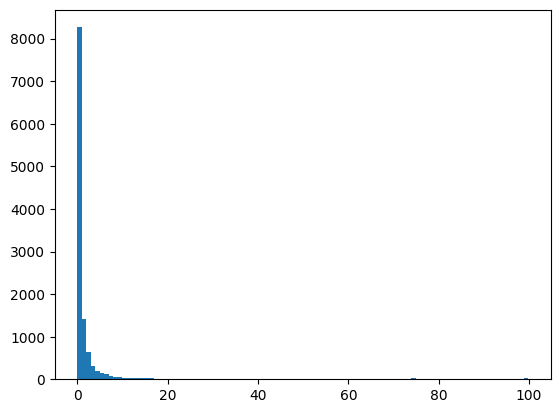

In [47]:
import matplotlib.pyplot as plt

plt.hist(dirty, bins=100)
# plt.xscale('log')
None

In [50]:
((dirty < 0.1) * 100.0).mean()

tensor(27.2313)

In [54]:
pth = '/home/ps5359/data/full_clean/cache/'
res = []
for i in tqdm(range(850)):
    x = torch.load(f'/home/ps5359/data/full_clean/cache/{i}.pt')[0]
    res.append(((abs(x) == 1e-4) * 100.0).mean())
clean = torch.tensor(res)

100%|██████████| 850/850 [00:33<00:00, 25.03it/s]


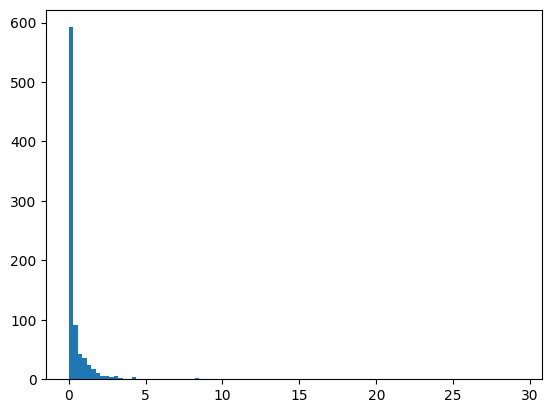

In [57]:
import matplotlib.pyplot as plt

plt.hist(clean, bins=100)
# plt.xscale('log')
None

In [58]:
((clean < 0.1) * 100.0).mean()

tensor(50.1176)

In [73]:
((dirty == 0) * 100.0).mean()

tensor(3.6297)

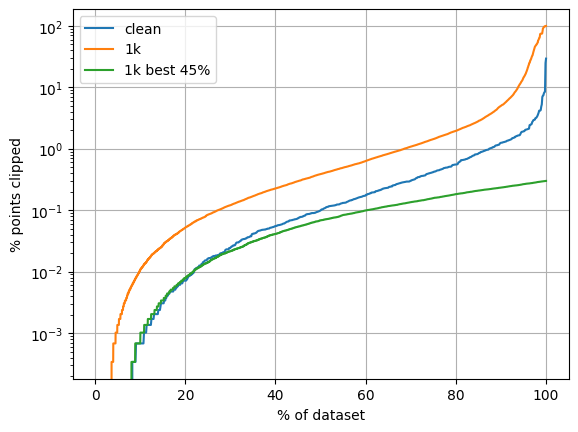

In [91]:
dirty_part = dirty[dirty < 0.3] 
plt.plot(100 * torch.arange(clean.shape[0]) / (clean.shape[0] - 1), torch.sort(clean).values, label='clean')
plt.plot(100 * torch.arange(dirty.shape[0]) / (dirty.shape[0] - 1), torch.sort(dirty).values, label='1k')
plt.plot(100 * torch.arange(dirty_part.shape[0]) / (dirty_part.shape[0] - 1), torch.sort(dirty_part).values, label=f'1k best {100.0 * dirty_part.shape[0] / dirty.shape[0]:.0f}%')
# plt.plot([0, 100], [0.1, 0.1])
# plt.plot([0, 100], [1, 1])
plt.legend()
plt.yscale('log')
plt.xlabel('% of dataset')
plt.ylabel('% points clipped')
plt.grid()

# Freq distribution

In [1]:
from torch import stft

def sp(x):
    n_fft=250
    hop_length=125
    spec = stft(x, n_fft=n_fft, window=torch.hann_window(n_fft), hop_length=hop_length, center=False, return_complex=True)
    spec = torch.view_as_real(spec)
    spec = torch.sqrt((spec * spec).sum(2))
    # spec = torch.log(spec)
    return spec


100%|██████████| 850/850 [00:37<00:00, 22.67it/s]


Text(0.5, 0, 'Hz')

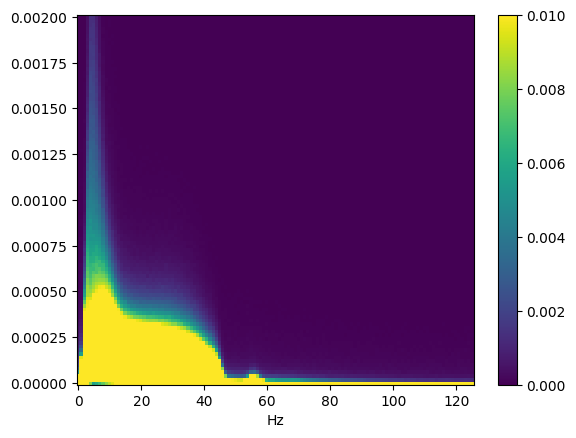

In [2]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

nbins = 100
hist_2d_clean = np.zeros((126, nbins))

pth = '/home/ps5359/data/full_clean/cache/'
res = []
total = 0
for i in tqdm(range(850)):
    x = torch.load(pth + f'{i}.pt')[0]
    q = sp(x[0])
    total += q.shape[1]
    for i in range(126):
        hist_2d_clean[i] += np.histogram(q[i], bins=nbins, range=(0, 2e-3))[0]
hist_2d_clean = hist_2d_clean / total
plt.pcolor(torch.arange(0, 126), torch.linspace(0, 2e-3, 100), hist_2d_clean.T, vmax=0.01)
plt.colorbar()
plt.xlabel('Hz')

100%|██████████| 850/850 [00:35<00:00, 24.10it/s]


Text(0.5, 0, 'Hz')

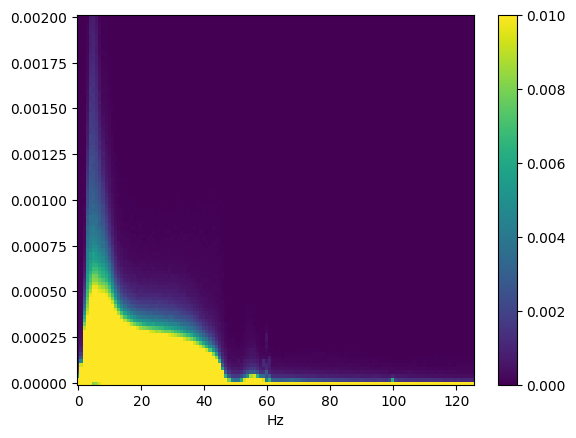

In [5]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os

nbins = 100
hist_2d_dirty = np.zeros((126, nbins))

pth = '/home/ps5359/data/1k/cache/'

l = os.listdir(pth)
np.random.shuffle(l)
l = l[:850]

res = []
total = 0
for i in tqdm(range(850)):
    x = torch.load(pth + l[i])[0]
    q = sp(x[0])
    total += q.shape[1]
    for i in range(126):
        hist_2d_dirty[i] += np.histogram(q[i], bins=nbins, range=(0, 2e-3))[0]
hist_2d_dirty = hist_2d_dirty / total
plt.pcolor(torch.arange(0, 126), torch.linspace(0, 2e-3, 100), hist_2d_dirty.T, vmax=0.01)
plt.colorbar()
plt.xlabel('Hz')

Text(0.5, 1.0, '850 sample cleaned 1k')

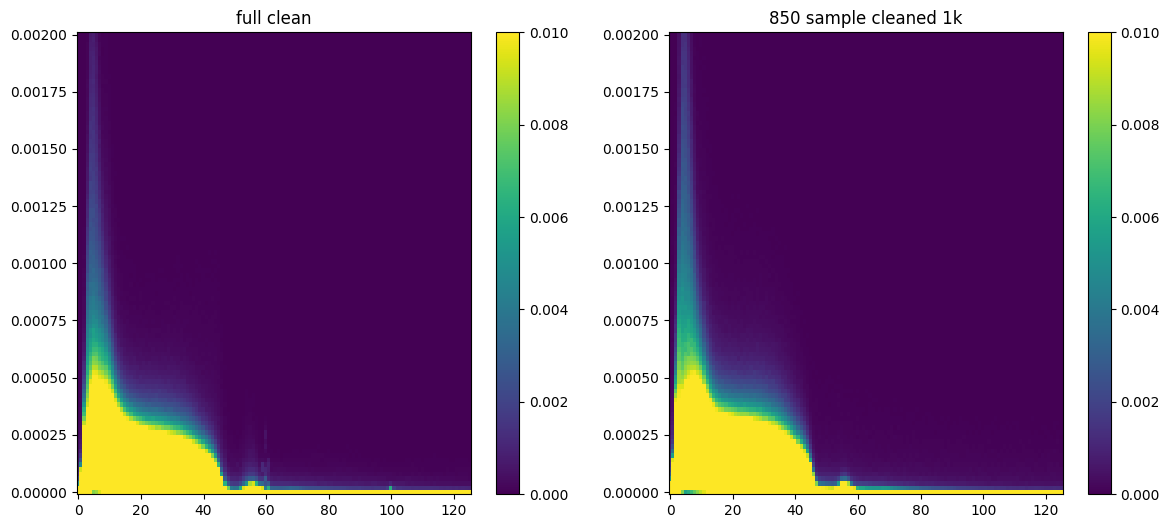

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

mx = 0.01
c0 = axs[0].pcolor(torch.arange(0, 126), torch.linspace(0, 2e-3, 100), hist_2d_dirty.T, vmax=mx)
c1 = axs[1].pcolor(torch.arange(0, 126), torch.linspace(0, 2e-3, 100), hist_2d_clean.T, vmax=mx)
fig.colorbar(c0, ax=axs[0])
fig.colorbar(c1, ax=axs[1])
axs[0].set_title('full clean')
axs[1].set_title('850 sample cleaned 1k')

Text(0.5, 1.0, 'dirty - clean')

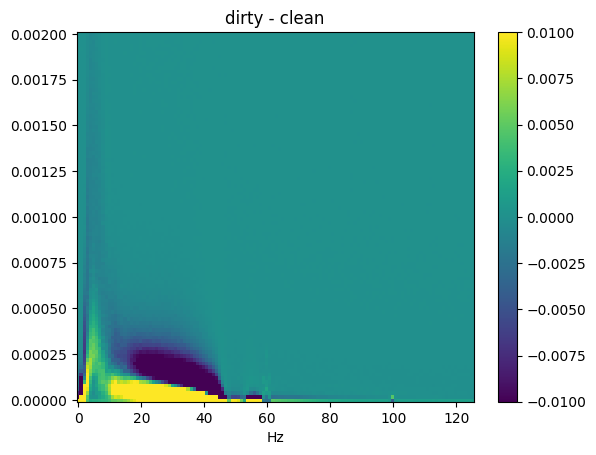

In [27]:
plt.pcolor(torch.arange(0, 126), torch.linspace(0, 2e-3, 100), (hist_2d_dirty - hist_2d_clean).T, vmax=0.01, vmin=-0.01)
plt.colorbar()
plt.xlabel('Hz')
plt.title('dirty - clean')